In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
from functools import partial
from sklearn.cluster import KMeans
import pickle
import datetime

from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AutoReg

from my_modules.plot_and_stat_funcs import *
from my_modules.transformations import *

In [2]:
def RMSPE(y_true, y_pred):
    y_t, y_p = np.array(y_true), np.array(y_pred)
    y_t, y_p = y_t[np.abs(y_t) > 1e-3], y_p[np.abs(y_t) > 1e-3]
    return np.sqrt(np.mean(
        ((y_t - y_p) / y_t)**2
    ))

Reading the data

In [3]:
data_folder = 'data/'

In [4]:
X_train = pd.read_csv(data_folder + 'X_train.csv')
y_train = pd.read_csv(data_folder + 'y_train.csv').target
X_val = pd.read_csv(data_folder + 'X_val.csv')
y_val = pd.read_csv(data_folder + 'y_val.csv').target
X_test = pd.read_csv(data_folder + 'X_test.csv')
test = pd.read_csv(data_folder + 'test.csv')
submission = pd.read_csv(data_folder + 'sample_submission.csv')

As I use only the information about stores that are present in the test dataset I remove the information about others.

In [5]:
test_store_ids = test.Store.unique()

In [6]:
is_train_in_test_mask = X_train.Store.isin(test_store_ids)
X_train = X_train[is_train_in_test_mask]
y_train = y_train[is_train_in_test_mask]

is_val_in_test_mask = X_val.Store.isin(test_store_ids)
X_val = X_val[is_val_in_test_mask]
y_val = y_val[is_val_in_test_mask]

In [7]:
max_train_day = 893
max_val_day = 893 + 48

In [8]:
train_sales = pd.concat([X_train, y_train], axis=1)
val_sales = pd.concat([X_val, y_val], axis=1)

In [9]:
store_ids = train_sales.Store.unique()
train_days = np.sort(train_sales.ordered_day.unique())
train_time_series = pd.DataFrame({
                store_id: time_series(train_sales, store_id=store_id, all_values=train_days).values
                for store_id in store_ids
            })

In [10]:
all_sales = pd.concat([train_sales, val_sales], axis=0, ignore_index=True)

In [11]:
all_store_ids = all_sales.Store.unique()
all_days = np.sort(all_sales.ordered_day.unique())
all_time_series = pd.DataFrame({
                store_id: time_series(all_sales, store_id=store_id, all_values=all_days).values
                for store_id in store_ids
            })

# TripleSmoothingModel

The formulas for triple smoothing model. l is level, b is trend, s is season.

$l_x=\alpha(y_x-s_{x-L})+(1-\alpha)(l_{x-1}+b_{x-1})$  
$b_x=\beta(l_x-l_{x-1})+(1-\beta)b_{x-1}$  
$s_x=\gamma(y_x-l_x)+(1-\gamma)s_{x-L}$  
$\hat{y}_{x+m}=l_x+mb_x+s_{x-L+1+(m-1)modL}$

In [12]:
class HoltWinters:

    """
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса

    """

    def __init__(self, slen, alpha, beta, gamma):
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def initial_trend(self):
        s = 0.0
        for i in range(self.slen):
            s += (self.series[i+self.slen] - self.series[i]) / self.slen
        return s / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def fit(self, series):
        self.series = series
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        
        # инициализируем значения компонент
        self.seasonals = self.initial_seasonal_components()
        smooth = self.series[0]
        trend = self.initial_trend()
        self.result.append(self.series[0])
        self.Smooth.append(smooth)
        self.Trend.append(trend)
        self.Season.append(self.seasonals[0])


        for i in range(1, len(self.series)):
            val = self.series[i]
            last_smooth, smooth = smooth, self.alpha*(val-self.seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
            trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
            self.seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*self.seasonals[i%self.slen]
            self.result.append(smooth+trend+self.seasonals[i%self.slen])
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(self.seasonals[i % self.slen])


        self.Smooth.append(smooth)
        self.Trend.append(trend)
        self.Season.append(self.seasonals[i % self.slen])
        return np.array(self.result)
    
    def predict(self, n_preds):
        smooth = self.Smooth[-1]
        trend = self.Trend[-1]
        result = []
        for i in range(len(self.series), len(self.series)+n_preds):
            m = i - len(self.series) + 1
            result.append((smooth + m*trend) + self.seasonals[i%self.slen])

        return np.array(result)
    
    def predict_from_start(self, N):
        if N <= len(self.result):
            return self.result[:N]
        return np.append(self.result, self.predict(N - len(self.result)), axis=0)

It is a class that uses the Holt-Winters model.

In [13]:
class TripleExpSmoothingCommon:
    
    def __init__(self, slen, alpha, beta, gamma):
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
    
    def fit(self, all_time_series):
        
        self.train_days = np.sort(all_time_series.index)
        self.store_ids = np.array(all_time_series.columns)
        
        self.hw_model = HoltWinters(self.slen, self.alpha, self.beta, self.gamma)
        self.hw_model.fit(all_time_series.values)
        return self
    
    def predict(self, X_test):
        stores = X_test.Store.unique()
        min_day, max_day = X_test.ordered_day.min(), X_test.ordered_day.max()
        prediction = self.hw_model.predict_from_start(max_day + 1)[min_day:]
        prediction = pd.DataFrame(prediction, columns=self.store_ids)\
                .unstack().reset_index().rename(columns={'level_0': 'Store', 'level_1': 'ordered_day', 0: 'prediction'})
        prediction.ordered_day += min_day
        return X_test.merge(prediction, on=['Store', 'ordered_day']).prediction.values

The function returns the rmspe of the Holt-Winters model with the parameters slen and x. x has 3 components - (alpha, beta, gamma). It is used to search the parameters that minimize the RMSPE.

In [14]:
def tesc_err(x, slen, val_sales=val_sales, all_time_series=train_time_series):
    tesc = TripleExpSmoothingCommon(slen, *x).fit(all_time_series=all_time_series)
    return RMSPE(val_sales.target, tesc.predict(val_sales))

# ClusteredModel

This class divide all the time series into clusters. For each cluster the best parameters are searched using minimize method from scipy.optimize module. This class contains refit. It just refit the Holt-Winters models but using the searched parameters.

In [15]:
class ClusteredModel:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def fit(self, val_sales=val_sales, all_time_series=train_time_series):
        all_time_series = all_time_series.loc[:, all_time_series.columns.sort_values()]
        all_ts = all_time_series.values.T
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=481).fit(all_ts)
        labels = kmeans.labels_

        self.store_ids = {
            label: all_time_series.columns[labels == label]
            for label in range(self.n_clusters)
        }
        self.models = []
        cube_vertices = list(product([0, 1], repeat=3))
        for label in range(self.n_clusters):
            ts_label = all_time_series.loc[:, labels==label]
            val = val_sales[val_sales.Store.isin(self.store_ids[label])]
            errs = []
            for vertex in cube_vertices:
                res = minimize(
                    lambda x: tesc_err(x, 14, val_sales=val, all_time_series=ts_label),
                    x0=vertex,
                    bounds=[(0, 1), (0, 1), (0, 1)]
                )
                errs.append((res.x, res.fun))
            best_params, err = min(errs, key=lambda x: x[1])
            tesc = TripleExpSmoothingCommon(14, *best_params).fit(all_time_series=ts_label)
            self.models.append(tesc)

    def refit(self, all_time_series=train_time_series):
        for label in range(self.n_clusters):
            ts_label = all_time_series.loc[:, all_time_series.columns.isin(self.store_ids[label])]
            self.models[label].fit(ts_label)

    def predict(self, X_test):
        
        pred = np.zeros(len(X_test))
        for label in range(self.n_clusters):
            store_mask = X_test.Store.isin(self.store_ids[label])
            if (~store_mask).all():
                continue
            pred[store_mask] = self.models[label].predict(X_test[store_mask])
        return pred

Here one Holt-Winters model for all the time series.

In [16]:
cm_common = ClusteredModel(1)
cm_common.fit(val_sales, train_time_series)
cm_common_prediction = cm_common.predict(val_sales)

RMSPE for one model.

In [17]:
RMSPE(val_sales.target, cm_common_prediction)

0.20101305360997523

Here 100 models for 100 clusters.

In [18]:
cm = ClusteredModel(100)
cm.fit(val_sales, train_time_series)
cm_prediction = cm.predict(val_sales)

RMSPE for 100 models.

In [19]:
RMSPE(val_sales.target, cm_prediction)

0.18913567197530126

So dividing into clusters decreases the error.

# Autoregression

This class fit autoregression model for each time series.

In [21]:
class ARPredictor:
    def __init__(self, lags):
        self.lags = lags
        
    def fit(self, all_time_series=all_time_series):
        
        self.train_days = np.array(all_time_series.index)
        self.store_ids = all_time_series.columns.unique()
        self.all_time_series = all_time_series.copy()
               
        self.all_models = {
            store_id: self.fit_model(self.all_time_series[store_id])
            for store_id in self.store_ids
        }
        return self
    
    def fit_model(self, ts):
        return AutoReg(ts.values, self.lags, old_names=True).fit()
    
    def predict_time_series(self, auto_reg_model, n_preds):
        start_day = self.train_days.max() + 1
        return auto_reg_model.predict(start=start_day, end=start_day + n_preds - 1)
    
    def predict(self, X_test):
        test_stores = X_test.Store.unique()
        all_days = np.sort(X_test.ordered_day.unique())
        n_preds = all_days.max() - self.train_days.max()
        start_pred, end_pred = self.train_days.max() + 1, all_days.max()
        predictions = [
            list(zip(
                [store_id] * n_preds,
                range(start_pred, end_pred + 1),
                self.predict_time_series(self.all_models[store_id], n_preds)
            ))
            for store_id in test_stores
        ]
        predictions = np.reshape(predictions, (np.size(predictions) // 3, 3))
        predictions = pd.DataFrame(predictions, columns=['Store', 'ordered_day', 'prediction'])
        return X_test.merge(predictions, on=['Store', 'ordered_day'])[['Store', 'ordered_day', 'prediction']].prediction

In [ ]:
arp_errs = []
lag_values = range(1, 31)
for lags in lag_values:
    arp = ARPredictor(lags).fit(train_time_series)
    val_predict = arp.predict(val_sales)
    arp_errs.append(RMSPE(val_sales.target, val_predict))

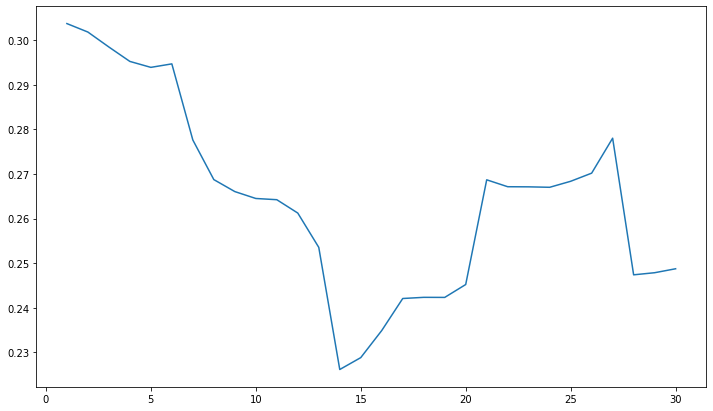

In [23]:
plt.figure(figsize=(12, 7))
plt.plot(lag_values, arp_errs)
plt.show()

In [24]:
min(arp_errs)

0.2261086572583279

The result is worse than for clustered model.

# Submitting

In [25]:
train_predict_df = X_train.copy()
train_predict_df.loc[:, 'target'] = y_train

val_predict_df = X_val.copy()
val_predict_df.loc[:, 'target'] = y_val

test_predict_df = X_test.copy()

In [26]:
train_prediction = cm.predict(X_train).clip(0)
val_prediction = cm.predict(X_val).clip(0)
test_prediction = cm.predict(X_test).clip(0)

In [27]:
train_predict_df.loc[:, 'part_prediction'] = train_prediction

val_predict_df.loc[:, 'part_prediction'] = val_prediction

test_predict_df.loc[:, 'part_prediction'] = test_prediction

In [28]:
cm.refit(all_time_series)

In [29]:
train_prediction = cm.predict(X_train).clip(0)
val_prediction = cm.predict(X_val).clip(0)
test_prediction = cm.predict(X_test).clip(0)

In [30]:
train_predict_df.loc[:, 'full_prediction'] = train_prediction

val_predict_df.loc[:, 'full_prediction'] = val_prediction

test_predict_df.loc[:, 'full_prediction'] = test_prediction

In [31]:
test['ordered_day'] = test.Date.apply(lambda date: (datetime.datetime.strptime(date, '%Y-%m-%d') - datetime.datetime(2013, 1, 1)).days)

In [32]:
pred_df = test[['Id', 'Store', 'ordered_day']].merge(test_predict_df[['Store', 'ordered_day', 'full_prediction']], on=['Store', 'ordered_day'])

In [33]:
submission = pd.read_csv(data_folder + 'sample_submission.csv')
submission.head(1)

,Id,Sales
0,1,0


In [34]:
submission = submission.merge(pred_df, on='Id', how='left')[['Id', 'full_prediction']].fillna(0).rename(columns={'full_prediction': 'Sales'})

In [35]:
submission.head()

,Id,Sales
0,1,3759.608749
1,2,6023.788585
2,3,9770.206587
3,4,6198.639518
4,5,6722.417668


In [36]:
submission.to_csv(data_folder + 'submission_tes.csv', index=False)

Final score - 0.31096

In [83]:
train_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'target', 'part_prediction', 'full_prediction']].to_csv(data_folder + 'train_prediction_ts.csv', index=False)
val_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'target', 'part_prediction', 'full_prediction']].to_csv(data_folder + 'val_prediction_ts.csv', index=False)
test_predict_df[['Store', 'ordered_day', 'ordered_week', 'ordered_month', 'part_prediction', 'full_prediction']].to_csv(data_folder + 'test_prediction_ts.csv', index=False)

# Analysis of error

IN PROGRESS

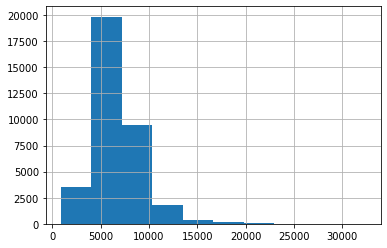

In [40]:
val_predict_df.part_prediction.hist()

In [42]:
val_predict_df['percent_error'] = (val_predict_df.part_prediction - val_predict_df.target) / val_predict_df.target

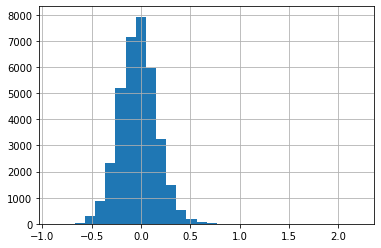

In [43]:
val_predict_df.percent_error.hist(bins=30)

In [52]:
rmspes = val_predict_df.groupby('Store').agg({'percent_error': lambda err: np.sqrt(np.mean(err**2))}).rename(columns={'percent_error': 'rmspe'})

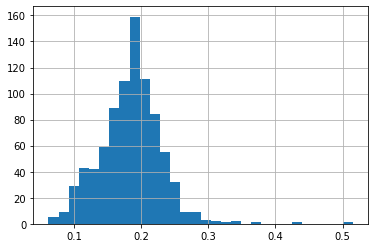

In [53]:
rmspes.rmspe.hist(bins=30)

In [64]:
for cluster_label, stores in cm.store_ids.items():
    print(stores)
    print(rmspes.loc[stores].mean())
    break

Int64Index([ 23,  30,  45,  91, 131, 166, 170, 244, 334, 341, 393, 451, 521,
            563, 690, 748, 800, 816, 833, 875, 916, 997],
           dtype='int64')
rmspe    0.207476
dtype: float64


In [80]:
np.array([np.array([np.array([cluster_label, store]) for store in stores]) for cluster_label, stores in cm.store_ids.items()]).flatten()#.flatten()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([array([[  0,  23],
       [  0,  30],
       [  0,  45],
       [  0,  91],
       [  0, 131],
       [  0, 166],
       [  0, 170],
       [  0, 244],
       [  0, 334],
       [  0, 341],
       [  0, 393],
       [  0, 451],
       [  0, 521],
       [  0, 563],
       [  0, 690],
       [  0, 748],
       [  0, 800],
       [  0, 816],
       [  0, 833],
       [  0, 875],
       [  0, 916],
       [  0, 997]]),
       array([[  1,  24],
       [  1,  27],
       [  1,  35],
       [  1,  71],
       [  1,  82],
       [  1, 269],
       [  1, 308],
       [  1, 731],
       [  1, 846]]),
       array([[  2, 733]]),
       array([[  3,  20],
       [  3, 139],
       [  3, 164],
       [  3, 181],
       [  3, 190],
       [  3, 243],
       [  3, 277],
       [  3, 413],
       [  3, 542],
       [  3, 670],
       [  3, 711],
       [  3, 712],
       [  3, 771],
       [  3, 806],
       [  3, 893],
       [  3, 932]]),
       array([[   4,   62],
       [   4,  623],
   

In [76]:
np.reshape(np.array([[[cluster_label, store] for store in stores] for cluster_label, stores in cm.store_ids.items()]).flatten(), (-1, 2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


array([[list([[0, 23], [0, 30], [0, 45], [0, 91], [0, 131], [0, 166], [0, 170], [0, 244], [0, 334], [0, 341], [0, 393], [0, 451], [0, 521], [0, 563], [0, 690], [0, 748], [0, 800], [0, 816], [0, 833], [0, 875], [0, 916], [0, 997]]),
        list([[1, 24], [1, 27], [1, 35], [1, 71], [1, 82], [1, 269], [1, 308], [1, 731], [1, 846]])],
       [list([[2, 733]]),
        list([[3, 20], [3, 139], [3, 164], [3, 181], [3, 190], [3, 243], [3, 277], [3, 413], [3, 542], [3, 670], [3, 711], [3, 712], [3, 771], [3, 806], [3, 893], [3, 932]])],
       [list([[4, 62], [4, 623], [4, 1072]]), list([[5, 383]])],
       [list([[6, 108], [6, 434], [6, 587], [6, 909], [6, 1080]]),
        list([[7, 171], [7, 448], [7, 510], [7, 535], [7, 536], [7, 616], [7, 665], [7, 707], [7, 765], [7, 826], [7, 967], [7, 1040]])],
       [list([[8, 56], [8, 111], [8, 300], [8, 350], [8, 369], [8, 371], [8, 618], [8, 661], [8, 723], [8, 740], [8, 832], [8, 866], [8, 937], [8, 943], [8, 960], [8, 1050]]),
        list([[9, 

In [ ]:
val_predict_df[['Store']]